In [21]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Activation, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import SeparableConv2D, GlobalAveragePooling2D, Lambda
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive

import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
% matplotlib inline
np.random.seed(2017)

drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EVA/Weights/"
!ls

# Hyperparameters
batch_size = 128
num_classes = 10

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


In [22]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
print(train_features.shape)
print(test_features.shape)

num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape

# num_classes=10
num_classes = len(np.unique(train_labels))
print(num_train, num_test, img_channels)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
50000 10000 3


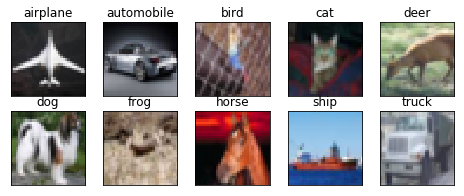

In [23]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))

for i in range(num_classes): #0-9
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])    
    idx = np.where(train_labels[:]==i)[0] #rows from training whose label=i, [1] gives the columns
    
    features_idx = train_features[idx,::] # shape:(5000, 32, 32, 3)
    img_num = np.random.randint(features_idx.shape[0]) #pick a random number from 0-5000
    im = features_idx[img_num]
    
    ax.set_title(class_names[i])
    plt.imshow(im)
    
plt.show()

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def conv_relu_bn(input, filters, kernel_size):
  layer = Conv2D(filters, kernel_size, padding='same', activation='relu')(input)
  output = BatchNormalization()(layer)
  return output

In [0]:
def sep_relu_bn(input, filters, kernel_size):
  layer = SeparableConv2D(filters, kernel_size, padding='same', activation='relu')(input)
  output = BatchNormalization()(layer)
  return output

In [0]:
# outputs a copy of the input tensor where values from the height and width dimensions are moved to the depth dimension. 
# for block_size=2, this function needs to be called thrice
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

#### Used the conv blocks and basic architecture from eNAS. And impl most of the skip connections in the code below. Then parameters inc to 2.8m which typically results in overfitting.


In [28]:
input = Input(shape=(img_rows, img_cols, img_channels,))

layer1 = sep_relu_bn(input, 16, 5)
print("Layer1 shape", layer1.shape)
temp1 = layer1
# Lambda function is used to wrap tf.Tensor to keras.Layer,
skip_con1 = Lambda(space_to_depth_x2)(temp1)
print("skip_con1 ", skip_con1.shape)
skip_con2 = Lambda(space_to_depth_x2)(skip_con1)
print(" skip_con2 shape ", skip_con2.shape)

layer2 = conv_relu_bn(layer1, 24, 5)
print("Layer2 shape", layer2.shape)

layer3 = conv_relu_bn(layer2, 32, 5)
print("Layer3 shape", layer3.shape)
temp2 = layer3
skip_con3 = Lambda(space_to_depth_x2)(temp2)
print("skip_con3 ", skip_con3.shape)
skip_con4 = Lambda(space_to_depth_x2)(skip_con3)
print(" skip_con4 shape ", skip_con4.shape)

concat1_3 = concatenate([temp1, layer3])
print("Concat of layer1 and layer3", concat1_3.shape)

layer4 = sep_relu_bn(concat1_3, 48, 5)
print("Layer4 shape", layer4.shape)
temp3 = layer4
skip_con5 = Lambda(space_to_depth_x2)(temp3)
print("skip_con5", skip_con5.shape)
skip_con6 = Lambda(space_to_depth_x2)(skip_con5)
print("skip_con6", skip_con6.shape)

concat1_4 = concatenate([temp1, layer4])
print("Concat of layer1 and layer4", concat1_4.shape)
                                     
layer5 = MaxPooling2D(pool_size=(2, 2))(concat1_4) #16
print("Layer5 maxpool shape", layer5.shape)

layer6 = sep_relu_bn(layer5, 32, 3)
print("Layer6 shape", layer6.shape)
temp4 = layer6
skip_con7 = Lambda(space_to_depth_x2)(temp4)
print("skip_con7", skip_con7.shape)
concat1_6 = concatenate([skip_con1, layer6])
print("Concat of layer1 and layer6", concat1_6.shape)
concat4_6 = concatenate([skip_con5, concat1_6])
print("Final concat of layer1 and layer4 and layer6", concat4_6.shape)

layer7 = conv_relu_bn(concat4_6, 48, 5)
print("Layer7 shape", layer7.shape)
concat3_7 = concatenate([skip_con3, layer7])
print("Concat of layer3 and layer7", concat3_7.shape)
concat4_7 = concatenate([skip_con5, concat3_7])
print("Concat of layer3, layer4 and layer7", concat4_7.shape)
concat6_7 = concatenate([temp4, concat4_7])
print("Final concat of layer3, layer4, layer6 and layer7", concat6_7.shape)

layer8 = sep_relu_bn(concat6_7, 64, 3)
print("Layer8 shape", layer8.shape)
temp5 = layer8
skip_con8 = Lambda(space_to_depth_x2)(temp5)
print("skip_con8", skip_con8.shape)
concat3_8 = concatenate([skip_con3, layer8])
print("Concat of layer3 and layer8", concat3_8.shape)
concat1_8 = concatenate([skip_con1, concat3_8])
print("Concat of layer1, layer3 and layer8", concat1_8.shape)
concat6_8 = concatenate([temp4, concat1_8])
print("Final concat of layer1, layer3, layer6 and layer8", concat6_8.shape)

layer9 = sep_relu_bn(concat6_8, 96, 5)
print("Layer9 shape", layer9.shape)
concat1_9 = concatenate([skip_con1, layer9])
print("Concat of layer1 and layer9", concat1_9.shape)
concat4_9 = concatenate([skip_con5, concat1_9])
print("Concat of layer1, layer4 and layer9", concat4_9.shape)
concat6_9 = concatenate([temp4, concat4_9])
print("Concat of layer1, layer4, layer6 and layer9", concat6_9.shape)
concat8_9 = concatenate([temp5, concat6_9])
print("Final concat of layer1, layer4, layer6 layer8 and layer9", concat8_9.shape)

layer10_1 = conv_relu_bn(concat8_9, 256, 1)
layer10 = MaxPooling2D(pool_size=(2, 2))(concat8_9) #8
print("Layer10 maxpool shape", layer10.shape)

layer11 = sep_relu_bn(layer10, 96, 5)
print("Layer11 shape", layer11.shape)
concat6_11 = concatenate([skip_con7, layer11])
print("Concat of layer6 and layer11", concat6_11.shape)
concat8_11 = concatenate([skip_con8, concat6_11])
print("Concat of layer6, layer8 and layer11", concat8_11.shape)

layer12 = conv_relu_bn(concat8_11, 128, 5)
print("Layer12 shape", layer12.shape)
temp6 = layer12
concat3_12 = concatenate([skip_con4, layer12])
print("Concat of layer3 and layer12", concat3_12.shape)

#layer10_1 = conv_relu_bn(concat3_12, 300, 1)    ## Added to reduce channels from 640 to 256
layer13 = sep_relu_bn(concat3_12, 144, 3)
print("Layer13 shape", layer13.shape)
concat1_13 = concatenate([skip_con2, layer13])
print("Concat of layer1 and layer13", concat1_13.shape)
concat3_13 = concatenate([skip_con4, concat1_13])
print("Concat of layer1, layer3 and layer13", concat3_13.shape)
concat4_13 = concatenate([skip_con6, concat3_13])
print("Concat of layer1, layer3, layer4 and layer13", concat4_13.shape)
concat8_13 = concatenate([skip_con8, concat4_13])
print("Concat of layer1, layer3, layer4 layer8 and layer13", concat8_13.shape)
concat12_13 = concatenate([temp6, concat8_13])
print("Final concat of layer1, layer3, layer4, layer8, layer12 and layer13", concat12_13.shape)

layer14 = sep_relu_bn(concat12_13, 192, 5)
print("Layer14 shape", layer14.shape)
concat4_14 = concatenate([skip_con6, layer14])
print("Concat of layer4 and layer14", concat4_14.shape)
concat8_14 = concatenate([skip_con8, concat4_14])
print("Concat of layer4, layer8 and layer14", concat8_14.shape)
concat12_14 = concatenate([temp6, concat8_14])
print("Concat of layer4, layer8, layer12 and layer14", concat12_14.shape)

layer15 = sep_relu_bn(concat12_14, 160, 1)
print("Layer15 shape", layer15.shape)
layer16 = sep_relu_bn(layer15, num_classes, 1)
print("Layer16 shape", layer16.shape)

gap = GlobalAveragePooling2D()(layer16)  # in place of Flatten
print(" GAP ", gap.shape)

output = Activation('softmax')(gap)
print("Output shape", output.shape)

Layer1 shape (?, 32, 32, 16)
skip_con1  (?, 16, 16, 64)
 skip_con2 shape  (?, 8, 8, 256)
Layer2 shape (?, 32, 32, 24)
Layer3 shape (?, 32, 32, 32)
skip_con3  (?, 16, 16, 128)
 skip_con4 shape  (?, 8, 8, 512)
Concat of layer1 and layer3 (?, 32, 32, 48)
Layer4 shape (?, 32, 32, 48)
skip_con5 (?, 16, 16, 192)
skip_con6 (?, 8, 8, 768)
Concat of layer1 and layer4 (?, 32, 32, 64)
Layer5 maxpool shape (?, 16, 16, 64)
Layer6 shape (?, 16, 16, 32)
skip_con7 (?, 8, 8, 128)
Concat of layer1 and layer6 (?, 16, 16, 96)
Final concat of layer1 and layer4 and layer6 (?, 16, 16, 288)
Layer7 shape (?, 16, 16, 48)
Concat of layer3 and layer7 (?, 16, 16, 176)
Concat of layer3, layer4 and layer7 (?, 16, 16, 368)
Final concat of layer3, layer4, layer6 and layer7 (?, 16, 16, 400)
Layer8 shape (?, 16, 16, 64)
skip_con8 (?, 8, 8, 256)
Concat of layer3 and layer8 (?, 16, 16, 192)
Concat of layer1, layer3 and layer8 (?, 16, 16, 256)
Final concat of layer1, layer3, layer6 and layer8 (?, 16, 16, 288)
Layer9 shape 

In [29]:
model = Model(inputs=[input], outputs=[output])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_31 (SeparableC (None, 32, 32, 16)   139         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 32, 32, 16)   64          separable_conv2d_31[0][0]        
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 24)   9624        batch_normalization_46[0][0]     
____________________________________________________________________________________________

#### Ran for fixed 50 epochs with no early stopping. Best validation accuracy was 79.47% which came at epoch 44, with training accuracy at 99.52. The gap between the two accuracies shows clear overfitting.

In [30]:
file = dir + "Assign7.{epoch:03d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=2)

model_info = model.fit(train_features, train_labels, batch_size=batch_size, epochs=50, verbose=1,
          validation_data=(test_features, test_labels), callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 111s 2ms/step - loss: 1.3198 - acc: 0.5537 - val_loss: 1.3972 - val_acc: 0.5575
Epoch 2/50
50000/50000 [==============================] - 106s 2ms/step - loss: 0.8794 - acc: 0.7141 - val_loss: 0.9341 - val_acc: 0.6893

Epoch 00002: val_acc improved from -inf to 0.68930, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign7.002-0.6893.hdf5
Epoch 3/50
50000/50000 [==============================] - 106s 2ms/step - loss: 0.6704 - acc: 0.7861 - val_loss: 0.7551 - val_acc: 0.7485
Epoch 4/50
50000/50000 [==============================] - 106s 2ms/step - loss: 0.5187 - acc: 0.8363 - val_loss: 0.8455 - val_acc: 0.7352

Epoch 00004: val_acc improved from 0.68930 to 0.73520, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign7.004-0.7352.hdf5
Epoch 5/50
50000/50000 [==============================] - 106s 2ms/step - loss: 0.3920 - acc: 0.8797 - 

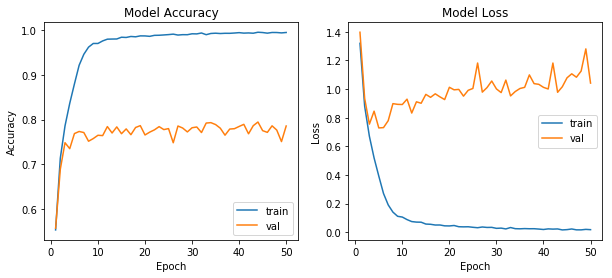

In [31]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    
    # Plot training & validation accuracy values
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Plot training & validation loss values
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(model_info)